## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [1]:
import os
import keras
import tensorflow as tf
# 本範例不需使用 GPU, 將 GPU 設定為 "無"
# 使用第一張 GPU 卡
os.environ["CUDA_VISIBLE_DEVICES"] = " 0 "
# 只使用 60% 的 GPU 記憶體
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.6)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

# 設定 Keras 使用的 TensorFlow Session
tf.keras.backend.set_session(sess)

Using TensorFlow backend.
C:\Users\Administrator\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Administrator\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Administrator\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Administrator\Anaconda3\lib\site-packages\tenso

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    # 資料前處理 - 標準化
    x = x / 255.
    if flatten:
        # 將資料從圖形 (RGB) 轉為向量 (Single Vector)
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        # 用np_utils裡的to_categorical來做one-hot encoding的轉換：
        y = keras.utils.to_categorical(y, num_classes)
    return y       

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)# 加入Batch Normalization，能夠將每一層的輸入/輸出做正規化
            '''
            參數:
            units=n_units: 建立有n_units個神經元的隱藏層
            kernel_regularizer: 權重(W)正規化(或稱 正則項)函數，作用是對權重矩陣加上懲罰性函數(Penalty)，以防止過度擬合(overfit)，參見 regularizer。
            activation='relu': 使用relu為激活函數
            '''
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)# 加入Batch Normalization，能夠將每一層的輸入/輸出做正規化
            '''
            參數:
            units=n_units: 建立有n_units個神經元的隱藏層
            kernel_regularizer: 權重(W)正規化(或稱 正則項)函數，作用是對權重矩陣加上懲罰性函數(Penalty)，以防止過度擬合(overfit)，參見 regularizer。
            activation='relu': 使用relu為激活函數
            '''
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3 # 學習率
EPOCHS = 50 # 訓練50週期，訓練集所有樣本（數據、記錄）參與訓練一次爲一個週期
BATCH_SIZE = 1024 # 訓練時每個批次的樣本數。訓練樣本數/批次樣本數 = 批次數（每個週期）
MOMENTUM = 0.95 # 動量

In [9]:
import tensorflow as tf
import keras.backend as K
"""Code Here
撰寫一個 loss function, 使其可以結合 focal loss 與 crossentropy loss
"""
def combined_loss(wei, gamma=2., alpha=4.):
    
    gamma = float(gamma)
    alpha = float(alpha)
    
    """Define the customized loss."""
    def combined_loss_tf(y_true, y_pred):
        
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32) # tf.convert_to_tensor:將給定值轉換爲張量。
        y_pred = tf.convert_to_tensor(y_pred, tf.float32) # tf.convert_to_tensor:將給定值轉換爲張量。

        model_out = tf.add(y_pred, epsilon) # tf.add對應元素相加
        # cross entropy
        ce = tf.multiply(y_true, -tf.log(model_out))# tf.multiply對應元素相乘、tf.log求自然對數
        # weight
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma)) # tf.multiply對應元素相乘、tf.pow求tf.subtract(1., model_out)各元素的 gamma各元素次方
        # focal_loss
        fl = tf.multiply(alpha, tf.multiply(weight, ce))# tf.multiply對應元素相乘。
        # reduced focal_loss
        reduced_fl = tf.reduce_max(fl, axis=1) # tf.reduce_max沿著維度axis計算最大值。
        # reduced cross entropy
        reduced_ce = tf.reduce_max(ce, axis=1) # tf.reduce_max沿著維度axis計算最大值。
        
        # 定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy 
        return tf.reduce_mean(reduced_fl*(1-wei) + reduced_ce*(wei))# tf.reduce_mean沿着維度axis計算均值 。
    
    return combined_loss_tf
ce_weights_list = [0.0, 0.3, 0.5, 0.7, 1]

In [10]:
import itertools
results = {}

for i, ce_w in enumerate(ce_weights_list): # enumerate()函數用於將一個可遍歷的數據對象(如列表、元組或字符串)組合為一個索引序列，同時列出數據和數據下標，
    print("Numbers of exp: %i, ce_weight: %.2f" % (i, ce_w))

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    """Code Here
    將自定義的 loss function 加入模型
    """
    model.compile(loss = combined_loss(ce_w), metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train,  # 訓練資料。
              epochs=EPOCHS, # 訓練EPOCHS週期，訓練集所有樣本（數據、記錄）參與訓練一次爲一個週期
              batch_size=BATCH_SIZE, # 訓練時每個批次的樣本數，訓練樣本數/批次樣本數 = 批次數（每個週期）
              validation_data=(x_test, y_test), # 驗證資料。
              shuffle=True # 每次epochs後，將訓練集打亂順序。
             )
    
    # Collect results
    '''
    History.history屬性記錄了損失函數和其他指標的數值隨epoch變化的情況，
    如果有驗證集的話，也包含了驗證集的這些指標變化情況
    '''
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, ce_weight: 0.00
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_6 (B

50000/50000 [==============================] - 3s 53us/step - loss: 0.3256 - accuracy: 0.9482 - val_loss: 4.4852 - val_accuracy: 0.4763
Epoch 42/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.2989 - accuracy: 0.9555 - val_loss: 4.6673 - val_accuracy: 0.4756
Epoch 43/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.2759 - accuracy: 0.9600 - val_loss: 4.6176 - val_accuracy: 0.4840
Epoch 44/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.2581 - accuracy: 0.9639 - val_loss: 4.7230 - val_accuracy: 0.4836
Epoch 45/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.2369 - accuracy: 0.9690 - val_loss: 4.8551 - val_accuracy: 0.4802
Epoch 46/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.2152 - accuracy: 0.9730 - val_loss: 4.8358 - val_accuracy: 0.4755
Epoch 47/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.1981 - accuracy: 0.9768 - val_loss: 4.8579

50000/50000 [==============================] - 3s 53us/step - loss: 0.8297 - accuracy: 0.8051 - val_loss: 2.4355 - val_accuracy: 0.4948
Epoch 32/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.7907 - accuracy: 0.8157 - val_loss: 2.4476 - val_accuracy: 0.4976
Epoch 33/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.7551 - accuracy: 0.8260 - val_loss: 2.4704 - val_accuracy: 0.5017
Epoch 34/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.7205 - accuracy: 0.8364 - val_loss: 2.4823 - val_accuracy: 0.4936
Epoch 35/50
50000/50000 [==============================] - 3s 53us/step - loss: 0.6867 - accuracy: 0.8448 - val_loss: 2.5666 - val_accuracy: 0.4911
Epoch 36/50
50000/50000 [==============================] - 3s 54us/step - loss: 0.6573 - accuracy: 0.8529 - val_loss: 2.6446 - val_accuracy: 0.4828
Epoch 37/50
50000/50000 [==============================] - 3s 54us/step - loss: 0.6250 - accuracy: 0.8627 - val_loss: 2.6463

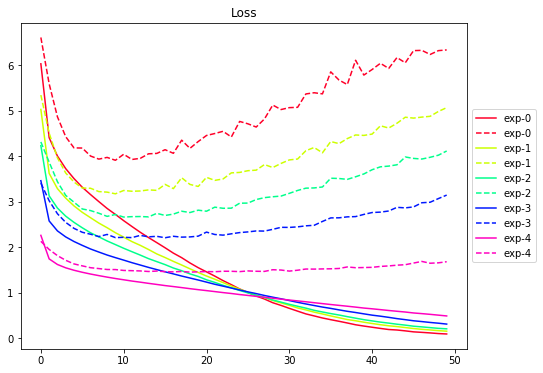

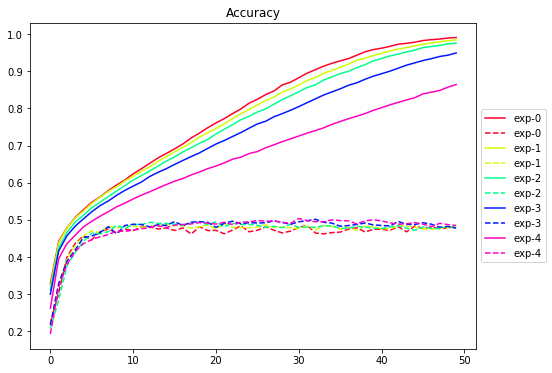

In [11]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()